# CNN Example
In this example, we will build a CNN-based neural network with ten units at the output layer that will help us classify a 28x28 pixel grayscale image as one of the ten categories. Torchvision datasets include API to download MNIST Fashion dataset.

Let’s begin by importing the required modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

We’ll need to define transforms to convert the data to the same required shape and format. We’ll then call FashionMNIST() to initialize the training and testing datasets which will download the data to the mentioned folder fashion_data if the data is not present.

In [2]:
all_transforms = transforms.Compose([
                    transforms.ToTensor()
                ])

train_data = torchvision.datasets.FashionMNIST ('fashion_data', train=True, download=True, transform=all_transforms)
test_data = torchvision.datasets.FashionMNIST ('fashion_data', train=False, transform=all_transforms)

This will install around 80MB compressed data. We can now initialize `DataLoader()` objects with a predefined batch_size.

In [3]:

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

We would recommend you to modify the batch_size as higher batch_sizes might also be appropriate in the systems with sufficient resources. Let’s check one batch of data items.

In [4]:
samples, labels = next(iter(train_loader))
samples.size()

torch.Size([64, 1, 28, 28])

This confirms that samples contain 64 elements, containing each sample of 28x28 shape. There’s only one grayscale channel in each image. Labels contain a tensor of size [64] that contains a number from 0 to 9 to represent the class each item falls in. Let’s create a mapping of MNIST Fashion labels so that we can refer to it when required:

In [5]:
def mnist_label(label):
    output_mapping = {
                        0: "T-shirt/Top",
                        1: "Trouser",
                        2: "Pullover",
                        3: "Dress",
                        4: "Coat",
                        5: "Sandal",
                        6: "Shirt",
                        7: "Sneaker",
                        8: "Bag",
                        9: "Ankle Boot"
                    }
    label = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[label]

Let’s try one item from the samples and check its label.

Pullover


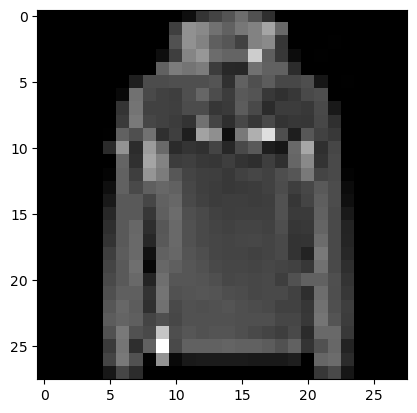

In [6]:
idx = 2
plt.imshow(samples[idx].squeeze(), cmap="gray")
print (mnist_label(labels[idx].item()))

To explore the data further, you can visualize multiple items in a grid. The following segment of code will produce an output similar to the figure below:

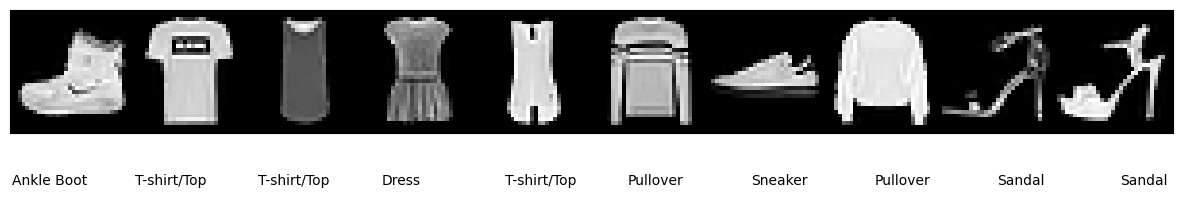

In [7]:
sample_loader = torch.utils.data.DataLoader(train_data, batch_size=10)
batch = next(iter(sample_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.imshow(np.transpose(grid, (1, 2, 0)))

for i, label in enumerate(labels):
    plt.text(32*i, 45, mnist_label(label))

Now that we have a clearer understanding of the data, we can proceed to design a neural network. In such networks, an interesting aspect to keep in mind is the sizes of tensors we’ll have as input and output in each layer. The input layer consists of a `1x28x28` pixel image. This will connect with a convolutional layer (conv2d), which takes input with one channel and produces 32 channels through 32 filters. This number is configurable and determines the complexity of this layer. Within this layer, we can use `ReLU as activations`. To simplify and make sure that the features extracted are more generic and translation invariant, we will add a two-dimensional max pooling layer. The size of max pooling will affect the design of following layers. Below figure summarizes the structure of the convolution part of the network.

![operations-in-cnn](images/operations-in-cnn.png)

In [8]:
convlayer = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=4, stride=4)
            )

Max pooling leads to generation of a `32x7x7` tensor, which we can forward to a dense network. We will create a dense layer with `32x7x7` inputs and arbitrarily 64 outputs. This also defines the next layer to be limited to 64 units. We know that output layer needs to have ten outputs. Below figure simplifies the final network we thus create.

![convolution-layers-followed-dense](images/convolution-layers-followed-dense.png)

Let’s create the model class for the network. As we saw in the previous chapter, we need to define the individual layers in the constructor and connect them together in a method called forward(), which will compute the outputs in the forward propagation phase. We will use the same definition of convolution layer as we saw in the previous page. Here’s the consolidated class.

In [9]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.convlayer = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4, stride=4)
                                    )
        self.fully_connected_layer_1 = nn.Linear(in_features=32*7*7, out_features=64)
        self.drop = nn.Dropout2d(0.25)
        self.fully_connected_layer_2 = nn.Linear(in_features=64, out_features=64)
        self.fully_connected_layer_3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        out = self.convlayer(x)
        out = out.view(out.size(0), -1)
        out = self.fully_connected_layer_1(out)
        out = self.drop(out)
        out = self.fully_connected_layer_2(out)
        out = self.fully_connected_layer_3(out)
        return out

You can see the details of the model thus being created by initializing an object of the class.

In [10]:
model = FashionCNN()
print(model)

FashionCNN(
  (convlayer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer_1): Linear(in_features=1568, out_features=64, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fully_connected_layer_2): Linear(in_features=64, out_features=64, bias=True)
  (fully_connected_layer_3): Linear(in_features=64, out_features=10, bias=True)
)


We can now initialize the loss function and optimizer and create a general loop for the training process. We will keep a track of the loss and accuracies as we’ve done before.

In [11]:
error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lstlosses = []
lstiterations = []
lstaccuracy = []

However, we can also use test data to find the test accuracy and track how train and test accuracy changed over the training period. The training loop will take care of three items: (1) iterate over train_loader and run forward and backpropagation to optimize the parameters, (2) iterate over test loader to predict labels of test data items and keep a log of test accuracy, and because the training process will be slow, (3) print or log a statement indicating the progress of the training process. Let’s create additional objects to track test items.

In [12]:
predictions_list = []
labels_list = []
num_epochs = 10 # Indicate maximum epochs for training
num_batches = 0 # Keep a track of batches of training data
batch_size = 100 # Configurable for tracking accuracy

for epoch in range(num_epochs):
    print ("Epoch: {} of {}".format(epoch+1, num_epochs))
    for images, labels in train_loader:
        train = Variable(images)
        labels = Variable(labels)

        outputs = model(train)
        loss = error(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1

        if num_batches % batch_size==0:
            total = 0
            matches = 0
            for images, labels in test_loader:
                labels_list.append(labels)
                test = Variable(images)
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                matches += (predictions == labels).sum()
                total += len(labels)
        
            accuracy = matches * 100 / total
            lstlosses.append(loss.data)
            lstiterations.append(num_batches)
            lstaccuracy.append(accuracy)
            
        if not (num_batches % batch_size):
            print(f"Iteration: {num_batches}, Loss: {loss.data:.4f}, Accuracy: {accuracy:.4f}%")

Epoch: 1 of 10


c:\Users\dm\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 100, Loss: 0.4311, Accuracy: 77.5700%
Iteration: 200, Loss: 0.3608, Accuracy: 81.9100%
Iteration: 300, Loss: 0.3495, Accuracy: 81.8200%
Iteration: 400, Loss: 0.2618, Accuracy: 85.3600%
Iteration: 500, Loss: 0.3836, Accuracy: 85.8900%
Iteration: 600, Loss: 0.4487, Accuracy: 86.5500%
Iteration: 700, Loss: 0.4643, Accuracy: 85.6500%
Iteration: 800, Loss: 0.3376, Accuracy: 86.0900%
Iteration: 900, Loss: 0.6199, Accuracy: 87.0800%
Epoch: 2 of 10
Iteration: 1000, Loss: 0.3734, Accuracy: 86.8000%
Iteration: 1100, Loss: 0.3479, Accuracy: 87.8400%
Iteration: 1200, Loss: 0.3459, Accuracy: 86.2000%
Iteration: 1300, Loss: 0.2078, Accuracy: 86.9200%
Iteration: 1400, Loss: 0.2388, Accuracy: 86.9800%
Iteration: 1500, Loss: 0.3490, Accuracy: 86.7400%
Iteration: 1600, Loss: 0.4651, Accuracy: 87.9400%
Iteration: 1700, Loss: 0.5380, Accuracy: 86.6200%
Iteration: 1800, Loss: 0.4786, Accuracy: 86.7300%
Epoch: 3 of 10
Iteration: 1900, Loss: 0.3304, Accuracy: 87.8800%
Iteration: 2000, Loss: 0.3310

For further experimentation and improvement of accuracy, you may choose to increase the number of conv2d layers or fully connected layers. Another factor to consider is the size of filters, max pooling length, and number of units in the fully connected layers. You can add more convolution layers and configure your network as follows:

In [13]:
# self.convlayer_2 = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,
#                         padding=1),
#                         nn.ReLU(),
#                         nn.MaxPool2d(kernel_size=4, stride=4)
#                     )

Changes like this often require you to reconsider the shape of every tensor that might be affected. Due to simplicity provided by PyTorch API, you only need to add how convlayer_2 will fit in forward(), and loss.backward() and optimizer.step() will update the parameters accordingly.

As we have logged losses and accuracy during training, we can understand how the model performed over the epochs by visualizing them using Matplotlib.

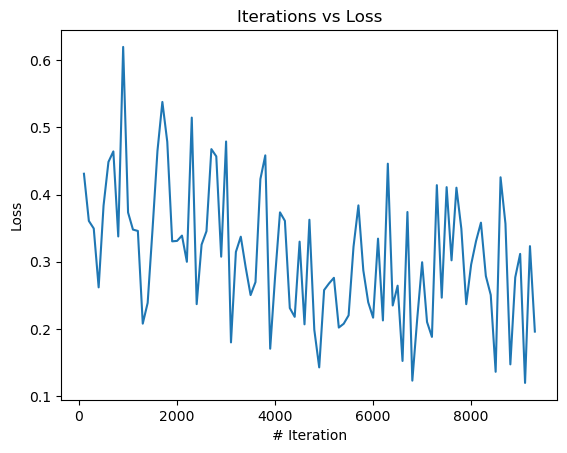

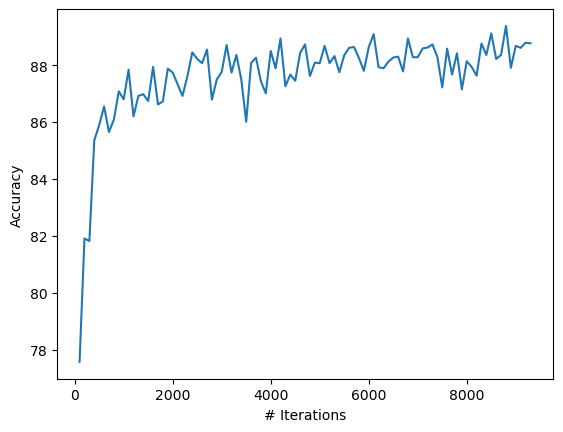

In [14]:
plt.plot(lstiterations, lstlosses)
plt.xlabel("# Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

plt.plot(lstiterations, lstaccuracy)
plt.xlabel("# Iterations")
plt.ylabel("Accuracy")
plt.show()

### What Did the Model Learn?
At any point, a model’s parameters (weights and biases) can be accessed using model. parameters(), which returns a generator for tensors that can be iterated over to get all the weights. The model contains parameter values as soon as it is initialized – mostly as random values, which get updated during the backpropagation.

In [15]:
list(model.parameters())[0].shape

torch.Size([32, 1, 3, 3])

The tensor returned at index 0 contains the 32 filters for convolution layer, present in the form of single-channel (grayscale) 3x3 size image. Let’s read their values and visualize to see what the convolution layer actually learned.

In [16]:
filters = list(model.parameters())[0]
filters

Parameter containing:
tensor([[[[ 5.9015e-02, -1.6703e-01,  1.1602e-01],
          [ 1.7858e-01, -2.6046e-01,  1.3958e-01],
          [ 1.6490e-02,  1.1738e-01, -2.6388e-01]]],


        [[[-9.9648e-01, -2.5230e-01, -2.2361e-01],
          [-3.3434e-01,  2.7740e-01,  1.6467e-01],
          [ 1.2707e-01, -6.0403e-02,  1.7697e-01]]],


        [[[-8.2758e-02,  6.5069e-02, -2.5121e-01],
          [-2.8255e-02, -7.2746e-03, -1.6680e-01],
          [-1.6208e-01, -1.5895e-01,  1.0965e-02]]],


        [[[ 4.1573e-03,  1.5233e-02, -1.0150e+00],
          [ 2.1949e-02, -5.1128e-01, -1.1096e+00],
          [-1.1858e+00, -7.3726e-01, -3.1054e+00]]],


        [[[-4.8344e-02, -1.1177e+00, -2.3638e+00],
          [-2.5818e-01,  4.0262e-01, -4.9236e-01],
          [ 1.7523e-01,  3.1783e-01, -2.9499e-01]]],


        [[[-2.9521e-01,  1.8419e-01, -4.0747e-01],
          [-2.4840e-01, -9.4072e-02,  1.6157e-01],
          [-1.7289e-01, -1.7339e-01, -1.5626e-01]]],


        [[[-3.9392e-01, -4.6671e-02,

This is truncated output showing the first two filters. We can visualize these values using Matplotlib. The output is shown below.


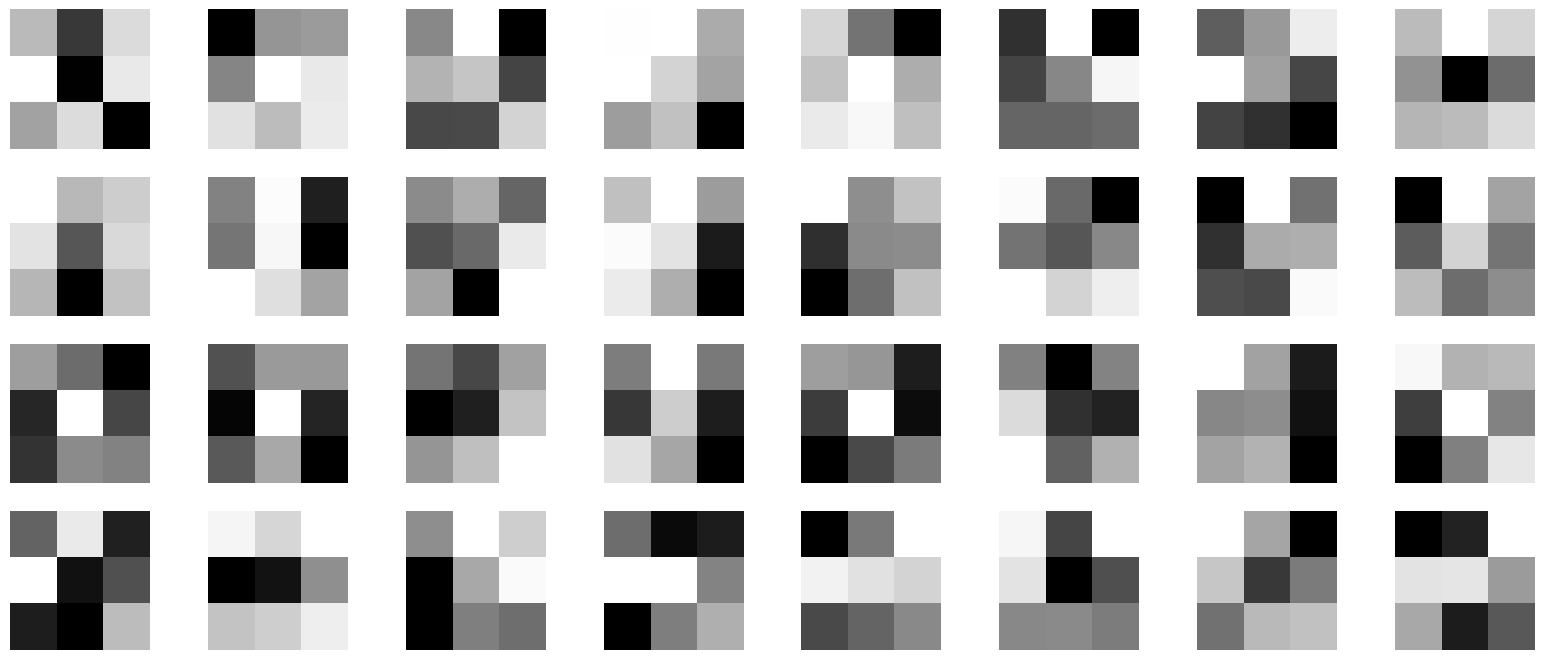

In [17]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(filters):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

Filters of larger size or filters of subsequent convolution layers can even show moreunderstandable features like collar of a shirt or heel of footwear. In many practical applications, more sophisticated networks with multiple convolution layers are built, which are followed by dense layers at the later end.